In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('CreditScoring_final.csv')
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,5,owner,18,29,married,0,fixed,45,142,6000,3000,450,1678
1,ok,12,owner,36,56,married,0,fixed,75,205,5500,1950,275,300
2,ok,2,parents,36,19,married,0,fixed,35,162,4000,100,400,570
3,ok,10,owner,48,50,married,0,freelance,45,128,11500,0,500,1195
4,ok,2,parents,36,34,married,0,fixed,60,400,9800,0,900,1316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,ok,20,other,60,39,married,0,fixed,60,119,0,0,1300,1639
3114,default,2,priv,60,53,married,0,fixed,75,85,7000,0,1050,1172
3115,ok,8,owner,48,52,married,0,fixed,60,105,3500,0,1000,1887
3116,ok,2,owner,36,30,married,0,fixed,45,350,4000,0,800,1800


Iată descrierile în română, păstrând denumirile coloanelor în engleză:

1. **Seniority** - Numărul de ani în care clientul a fost angajat sau a avut un anumit loc de muncă.

2. **Home** - Tipul de proprietate sau situația locativă în care se află clientul.

3. **Time** - Durata împrumutului în luni, solicitată de client.

4. **Age** - Vârsta clientului.

5. **Marital** - Starea civilă a clientului.

6. **Records** - Indică dacă clientul are înregistrări financiare negative (de exemplu, neplăți anterioare):
    - 0: Fără înregistrări negative
    - 1: Are înregistrări negative

7. **Job** - Tipul de muncă pe care îl are clientul.

8. **Expenses** - Cheltuielile lunare ale clientului, reprezentând suma totală cheltuită pentru costurile esențiale de trai.

9. **Income** - Venitul lunar al clientului, reprezentând cât câștigă.

10. **Assets** - Valoarea totală a activelor clientului, inclusiv economiile sau proprietățile deținute.

11. **Debt** - Totalul datoriilor restante ale clientului, reprezentând suma pe care o datorează instituțiilor financiare sau altor creditori.

12. **Amount** - Suma totală a împrumutului solicitat de client.

13. **Price** - Prețul bunului sau serviciului pe care împrumutul este destinat să-l finanțeze (de exemplu, prețul unei mașini sau al unui aparat).

14. **Status** - Starea creditului clientului, indicând dacă a fost sau nu în incapacitate de plată a împrumutului:
   - 0: Fără incapacitate de plată
   - 1: Incapacitate de plată

In [3]:
df.records.value_counts()

records
0    2559
1     559
Name: count, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118 entries, 0 to 3117
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   status     3117 non-null   object
 1   seniority  3118 non-null   int64 
 2   home       3114 non-null   object
 3   time       3118 non-null   int64 
 4   age        3118 non-null   int64 
 5   marital    3118 non-null   object
 6   records    3118 non-null   int64 
 7   job        3117 non-null   object
 8   expenses   3118 non-null   int64 
 9   income     3118 non-null   int64 
 10  assets     3118 non-null   int64 
 11  debt       3118 non-null   int64 
 12  amount     3118 non-null   int64 
 13  price      3118 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 341.2+ KB


In [5]:
df.isna().sum()

status       1
seniority    0
home         4
time         0
age          0
marital      0
records      0
job          1
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [6]:
df.describe().astype(int)

,seniority,time,age,records,expenses,income,assets,debt,amount,price
count,3118,3118,3118,3118,3118,3118,3118,3118,3118,3118
mean,8,46,37,0,55,769853,1224097,449342,1038,1462
std,8,14,11,0,19,8740952,10973301,6686778,476,640
min,0,6,18,0,35,0,0,0,100,105
25%,2,36,28,0,35,80,0,0,700,1114
50%,5,48,36,0,51,120,3500,0,1000,1400
75%,12,60,45,0,73,166,6000,0,1300,1685
max,47,72,68,1,180,99999999,99999999,99999999,5000,11140


In [7]:
df['status'].isna().sum()

np.int64(1)

In [8]:
df = df[df.status.notnull()]

In [9]:
def status_to_int(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[:, 'status'] = (df.loc[:, 'status'].map({'ok': 1, 'default': 0}))
    df['status'] = df['status'].astype(int)

    return df

In [10]:
df = status_to_int(df)

C:\Users\Home\AppData\Local\Temp\ipykernel_1044\832745710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].astype(int)


In [11]:
df.status.info()

<class 'pandas.core.series.Series'>
Index: 3117 entries, 0 to 3117
Series name: status
Non-Null Count  Dtype
--------------  -----
3117 non-null   int64
dtypes: int64(1)
memory usage: 48.7 KB


In [12]:
def show_frequency(df: pd.DataFrame, rows: int=3, cols: int=3):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, cols*3))

    for i in tqdm(range(cols)):
        for i2, c in tqdm(enumerate(df.iloc[:, cols*i:cols*(i+1)].columns)):
            axs[i2, i].hist(df[c], bins=20)
            axs[i2, i].set_xlabel(c)
            axs[i2, i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

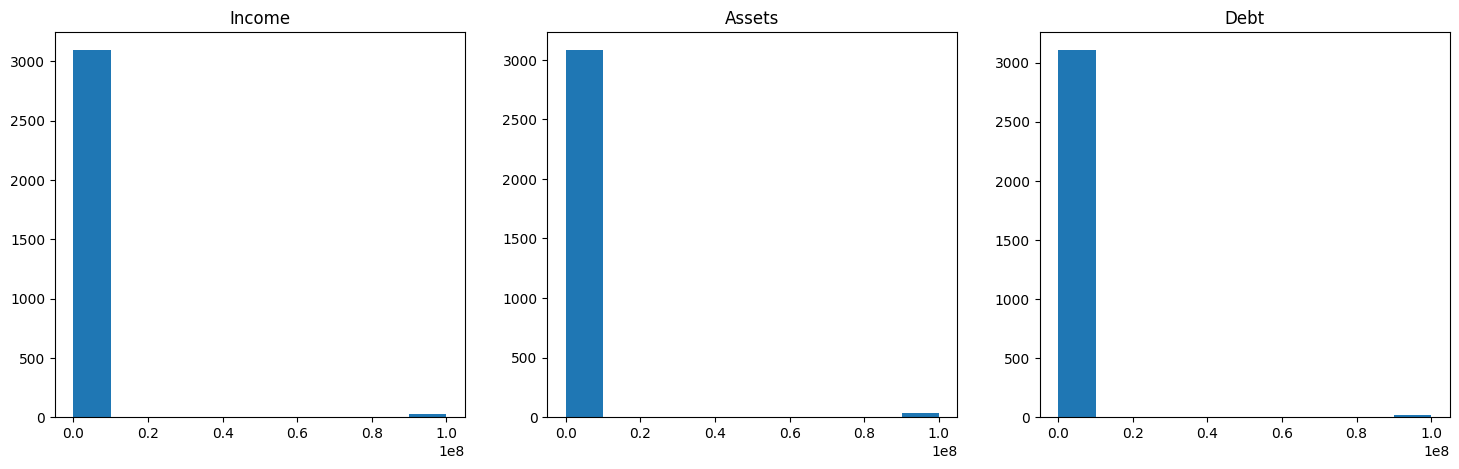

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].hist(df.income)
axs[0].title.set_text('Income')

axs[1].hist(df.assets)
axs[1].title.set_text('Assets')

axs[2].hist(df.debt)
axs[2].title.set_text('Debt')

plt.show()

In [14]:
def delete_extreme_val(df: pd.DataFrame) -> pd.DataFrame:
    df[['income', 'assets', 'debt']] = df[['income', 'assets', 'debt']].replace({99999999: np.nan})

    return df

In [15]:
df = delete_extreme_val(df)
df[['income', 'assets', 'debt']].describe().astype(int)

C:\Users\Home\AppData\Local\Temp\ipykernel_1044\903179467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['income', 'assets', 'debt']] = df[['income', 'assets', 'debt']].replace({99999999: np.nan})


,income,assets,debt
count,3093,3079,3103
mean,130,5434,338
std,87,11311,1249
min,0,0,0
25%,80,0,0
50%,119,3000,0
75%,165,6000,0
max,959,300000,30000


<Axes: xlabel='assets', ylabel='count'>

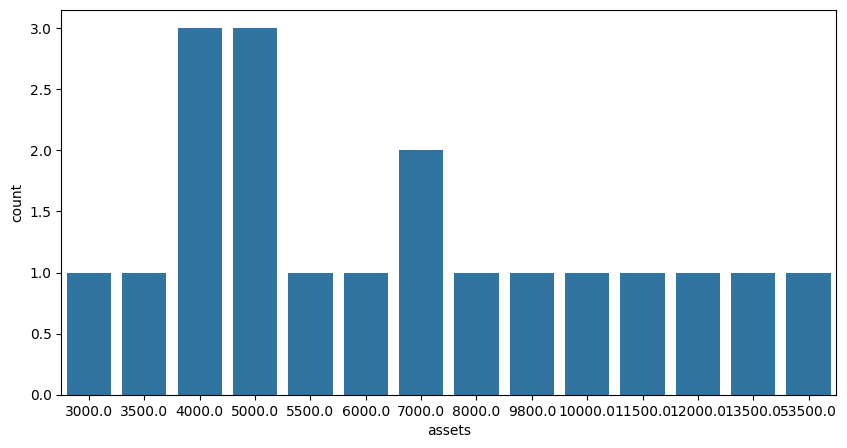

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x='assets', data=df[df['assets'] != 0].iloc[:20, :])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3117 entries, 0 to 3117
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   status     3117 non-null   int64  
 1   seniority  3117 non-null   int64  
 2   home       3113 non-null   object 
 3   time       3117 non-null   int64  
 4   age        3117 non-null   int64  
 5   marital    3117 non-null   object 
 6   records    3117 non-null   int64  
 7   job        3116 non-null   object 
 8   expenses   3117 non-null   int64  
 9   income     3093 non-null   float64
 10  assets     3079 non-null   float64
 11  debt       3103 non-null   float64
 12  amount     3117 non-null   int64  
 13  price      3117 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 365.3+ KB


In [18]:
def get_dummies(df: pd.DataFrame):
    df = pd.get_dummies(df, columns=['home', 'marital', 'job'])

    return df

In [19]:
df = get_dummies(df)

In [20]:
df.loc[:, df.dtypes == bool] = df.loc[:, df.dtypes == bool].apply(lambda x: x.map({True: 0, False: 1}))

C:\Users\Home\AppData\Local\Temp\ipykernel_1044\2547460094.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.dtypes == bool] = df.loc[:, df.dtypes == bool].apply(lambda x: x.map({True: 0, False: 1}))
C:\Users\Home\AppData\Local\Temp\ipykernel_1044\2547460094.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.dtypes == bool] = df.loc[:, df.dtypes == bool].apply(lambda x: x.map({True: 0, False: 1}))
C:\Users\Home\AppData\Local\Temp\ipykernel_1044\2547460094.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 0 0]' has dtype 

In [21]:
df

,status,seniority,time,age,records,expenses,income,assets,debt,amount,...,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
0,1,5,18,29,0,45,142.0,6000.0,3000.0,450,...,1,1,0,1,1,1,0,1,1,1
1,1,12,36,56,0,75,205.0,5500.0,1950.0,275,...,1,1,0,1,1,1,0,1,1,1
2,1,2,36,19,0,35,162.0,4000.0,100.0,400,...,1,1,0,1,1,1,0,1,1,1
3,1,10,48,50,0,45,128.0,11500.0,0.0,500,...,1,1,0,1,1,1,1,0,1,1
4,1,2,36,34,0,60,400.0,9800.0,0.0,900,...,1,1,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,1,20,60,39,0,60,119.0,0.0,0.0,1300,...,1,1,0,1,1,1,0,1,1,1
3114,0,2,60,53,0,75,85.0,7000.0,0.0,1050,...,1,1,0,1,1,1,0,1,1,1
3115,1,8,48,52,0,60,105.0,3500.0,0.0,1000,...,1,1,0,1,1,1,0,1,1,1
3116,1,2,36,30,0,45,350.0,4000.0,0.0,800,...,1,1,0,1,1,1,0,1,1,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3117 entries, 0 to 3117
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             3117 non-null   int64  
 1   seniority          3117 non-null   int64  
 2   time               3117 non-null   int64  
 3   age                3117 non-null   int64  
 4   records            3117 non-null   int64  
 5   expenses           3117 non-null   int64  
 6   income             3093 non-null   float64
 7   assets             3079 non-null   float64
 8   debt               3103 non-null   float64
 9   amount             3117 non-null   int64  
 10  price              3117 non-null   int64  
 11  home_ignore        3117 non-null   int64  
 12  home_other         3117 non-null   int64  
 13  home_owner         3117 non-null   int64  
 14  home_parents       3117 non-null   int64  
 15  home_priv          3117 non-null   int64  
 16  home_rent          3117 non-n

In [23]:
df.describe().astype(int)

,status,seniority,time,age,records,expenses,income,assets,debt,amount,...,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
count,3117,3117,3117,3117,3117,3117,3093,3079,3103,3117,...,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117
mean,0,8,46,37,0,55,130,5434,338,1037,...,0,0,0,0,0,0,0,0,0,0
std,0,8,14,11,0,19,87,11311,1249,476,...,0,0,0,0,0,0,0,0,0,0
min,0,0,6,18,0,35,0,0,0,100,...,0,0,0,0,0,0,0,0,0,0
25%,0,2,36,28,0,35,80,0,0,700,...,1,1,0,1,1,1,0,1,1,1
50%,1,5,48,36,0,51,119,3000,0,1000,...,1,1,0,1,1,1,0,1,1,1
75%,1,12,60,45,0,73,165,6000,0,1300,...,1,1,1,1,1,1,1,1,1,1
max,1,47,72,68,1,180,959,300000,30000,5000,...,1,1,1,1,1,1,1,1,1,1


In [24]:
print(df.assets.count())
print(df.status.count() - df.assets.isna().sum())

3079
3079


In [25]:
print(df.status.value_counts())

status
1    2236
0     881
Name: count, dtype: int64


In [26]:
pd.set_option('display.max_columns', 50)
df

,status,seniority,time,age,records,expenses,income,assets,debt,amount,price,home_ignore,home_other,home_owner,home_parents,home_priv,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
0,1,5,18,29,0,45,142.0,6000.0,3000.0,450,1678,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
1,1,12,36,56,0,75,205.0,5500.0,1950.0,275,300,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
2,1,2,36,19,0,35,162.0,4000.0,100.0,400,570,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1
3,1,10,48,50,0,45,128.0,11500.0,0.0,500,1195,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
4,1,2,36,34,0,60,400.0,9800.0,0.0,900,1316,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,1,20,60,39,0,60,119.0,0.0,0.0,1300,1639,1,0,1,1,1,1,1,0,1,1,1,0,1,1,1
3114,0,2,60,53,0,75,85.0,7000.0,0.0,1050,1172,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1
3115,1,8,48,52,0,60,105.0,3500.0,0.0,1000,1887,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
3116,1,2,36,30,0,45,350.0,4000.0,0.0,800,1800,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1


In [27]:
df.isna().sum()

status                0
seniority             0
time                  0
age                   0
records               0
expenses              0
income               24
assets               38
debt                 14
amount                0
price                 0
home_ignore           0
home_other            0
home_owner            0
home_parents          0
home_priv             0
home_rent             0
marital_divorced      0
marital_married       0
marital_separated     0
marital_single        0
marital_widow         0
job_fixed             0
job_freelance         0
job_others            0
job_partime           0
dtype: int64

In [28]:
def visualization_correlation(data: pd.DataFrame):
    plt.figure(figsize=(25, 10))
    sns.heatmap(data=data.corr(), annot=True)
    plt.show()

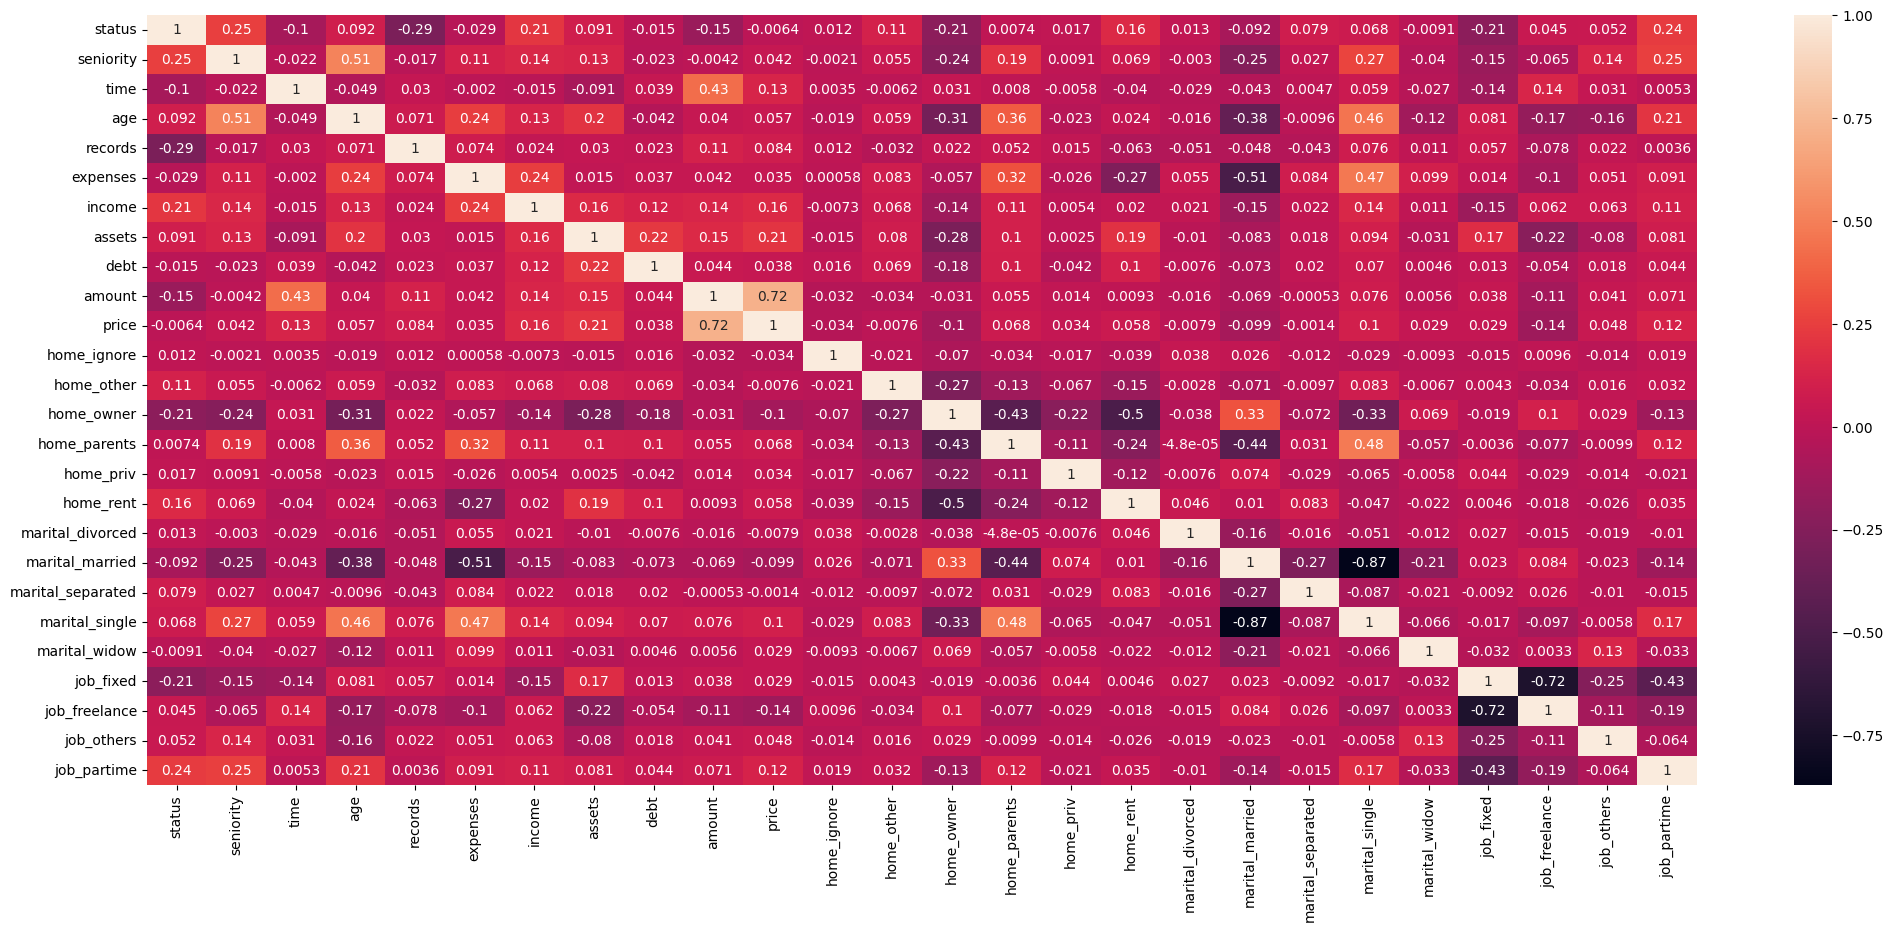

In [29]:

visualization_correlation(df)

# Concluzii
- Corelatia intre **amount** si **price** e cea mai mare dintre toate
- **seniority** are corelatie cu coloana **status**, 0.25
- **age** are corelatie distul de mare cu **seniority**, 0.51
- **home_ignoe** nu are o corelatie semnificativa cu careva din coloane, fa fel si **home_owner**, **home_priv**, **homediverced**, **marital_separated**

# Ipoteze
- Sar putea de eliminat coloanele mentionate mai sus de home si marital

In [30]:
df.iloc[:, :11]

,status,seniority,time,age,records,expenses,income,assets,debt,amount,price
0,1,5,18,29,0,45,142.0,6000.0,3000.0,450,1678
1,1,12,36,56,0,75,205.0,5500.0,1950.0,275,300
2,1,2,36,19,0,35,162.0,4000.0,100.0,400,570
3,1,10,48,50,0,45,128.0,11500.0,0.0,500,1195
4,1,2,36,34,0,60,400.0,9800.0,0.0,900,1316
...,...,...,...,...,...,...,...,...,...,...,...
3113,1,20,60,39,0,60,119.0,0.0,0.0,1300,1639
3114,0,2,60,53,0,75,85.0,7000.0,0.0,1050,1172
3115,1,8,48,52,0,60,105.0,3500.0,0.0,1000,1887
3116,1,2,36,30,0,45,350.0,4000.0,0.0,800,1800


In [31]:
def show_boxplots(df: pd.DataFrame, rows: int=3, cols: int=3):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, cols*3))

    for i in tqdm(range(cols)):
        for i2, c in tqdm(enumerate(df.iloc[:, cols*i:cols*(i+1)].columns)):
            axs[i2, i].boxplot(df[c])
            axs[i2, i].set_title(c)
    
    plt.tight_layout()
    plt.show()

5it [00:00, 95.88it/s]00:00<?, ?it/s]
5it [00:00, 85.24it/s]
5it [00:00, 101.83it/s]0:00<00:00, 16.22it/s]
5it [00:00, 127.77it/s]
5it [00:00, 123.12it/s]0:00<00:00, 18.03it/s]
100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


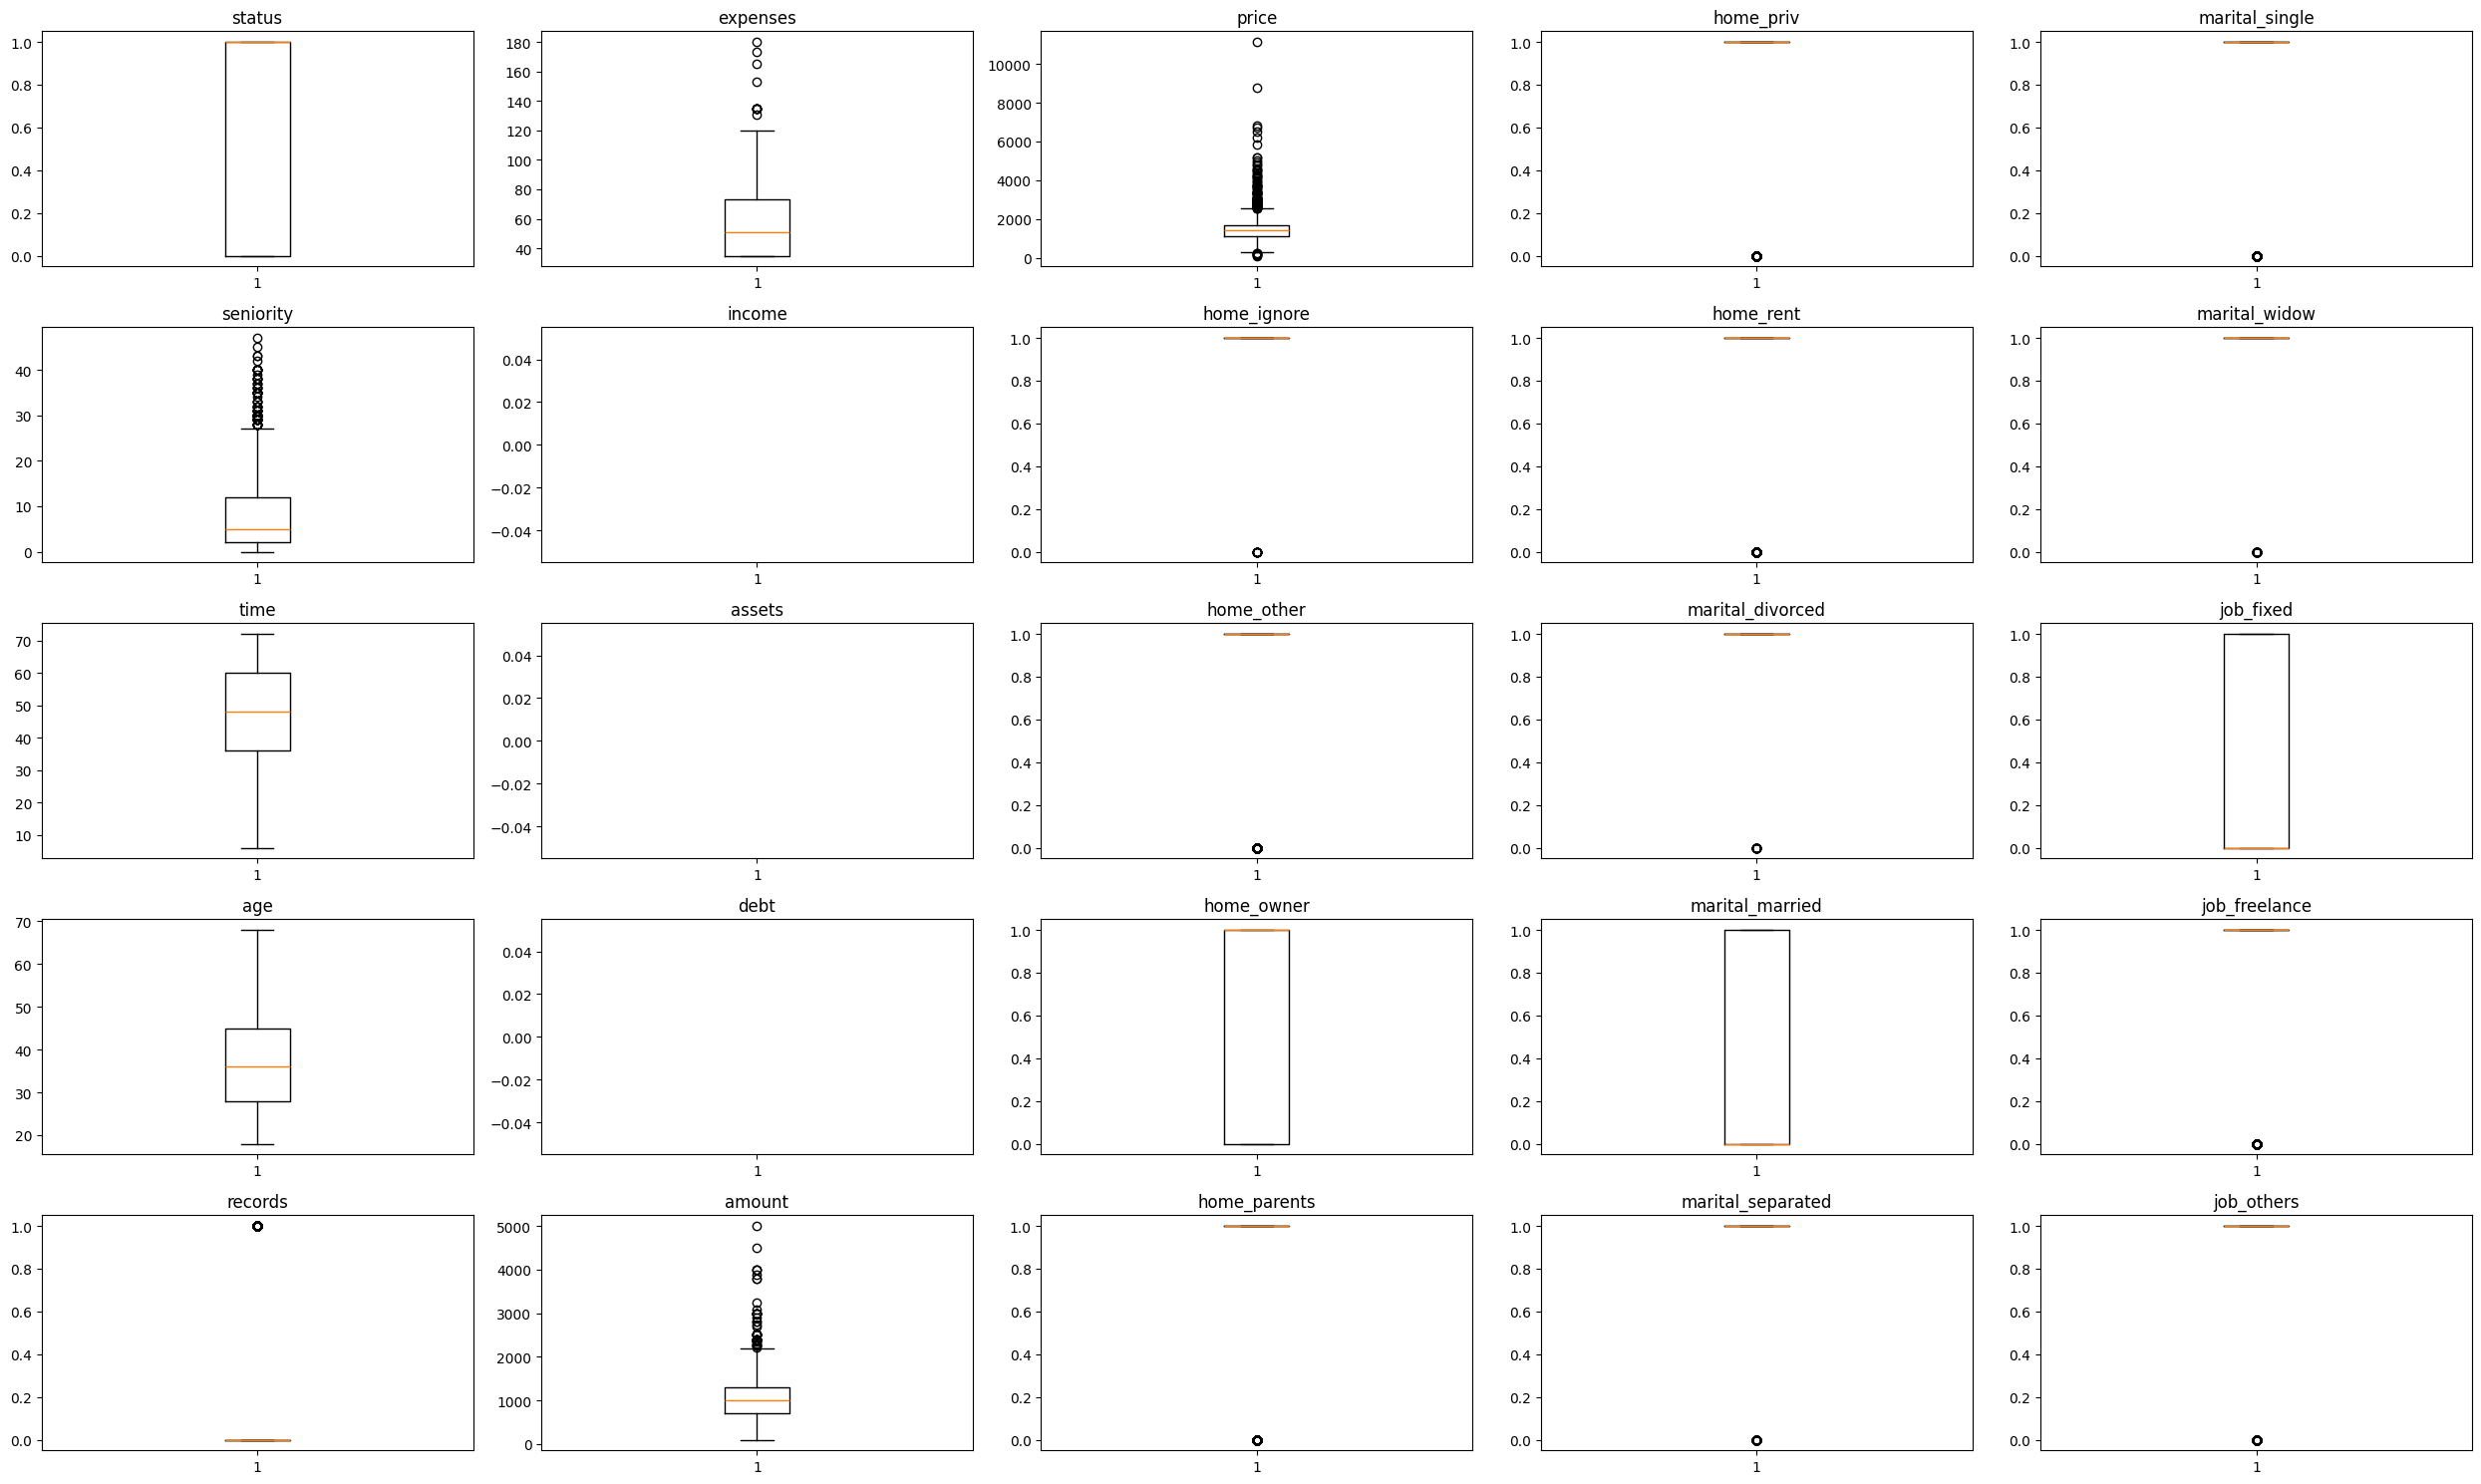

In [32]:
#plt.boxplot(df['price'])
show_boxplots(df, rows=5, cols=5)

5it [00:00, 48.41it/s]00:00<?, ?it/s]
5it [00:00, 53.33it/s]00:00<00:00,  9.36it/s]
5it [00:00, 24.44it/s]
5it [00:00, 59.36it/s]00:00<00:00,  7.03it/s]
5it [00:00, 57.98it/s]
100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


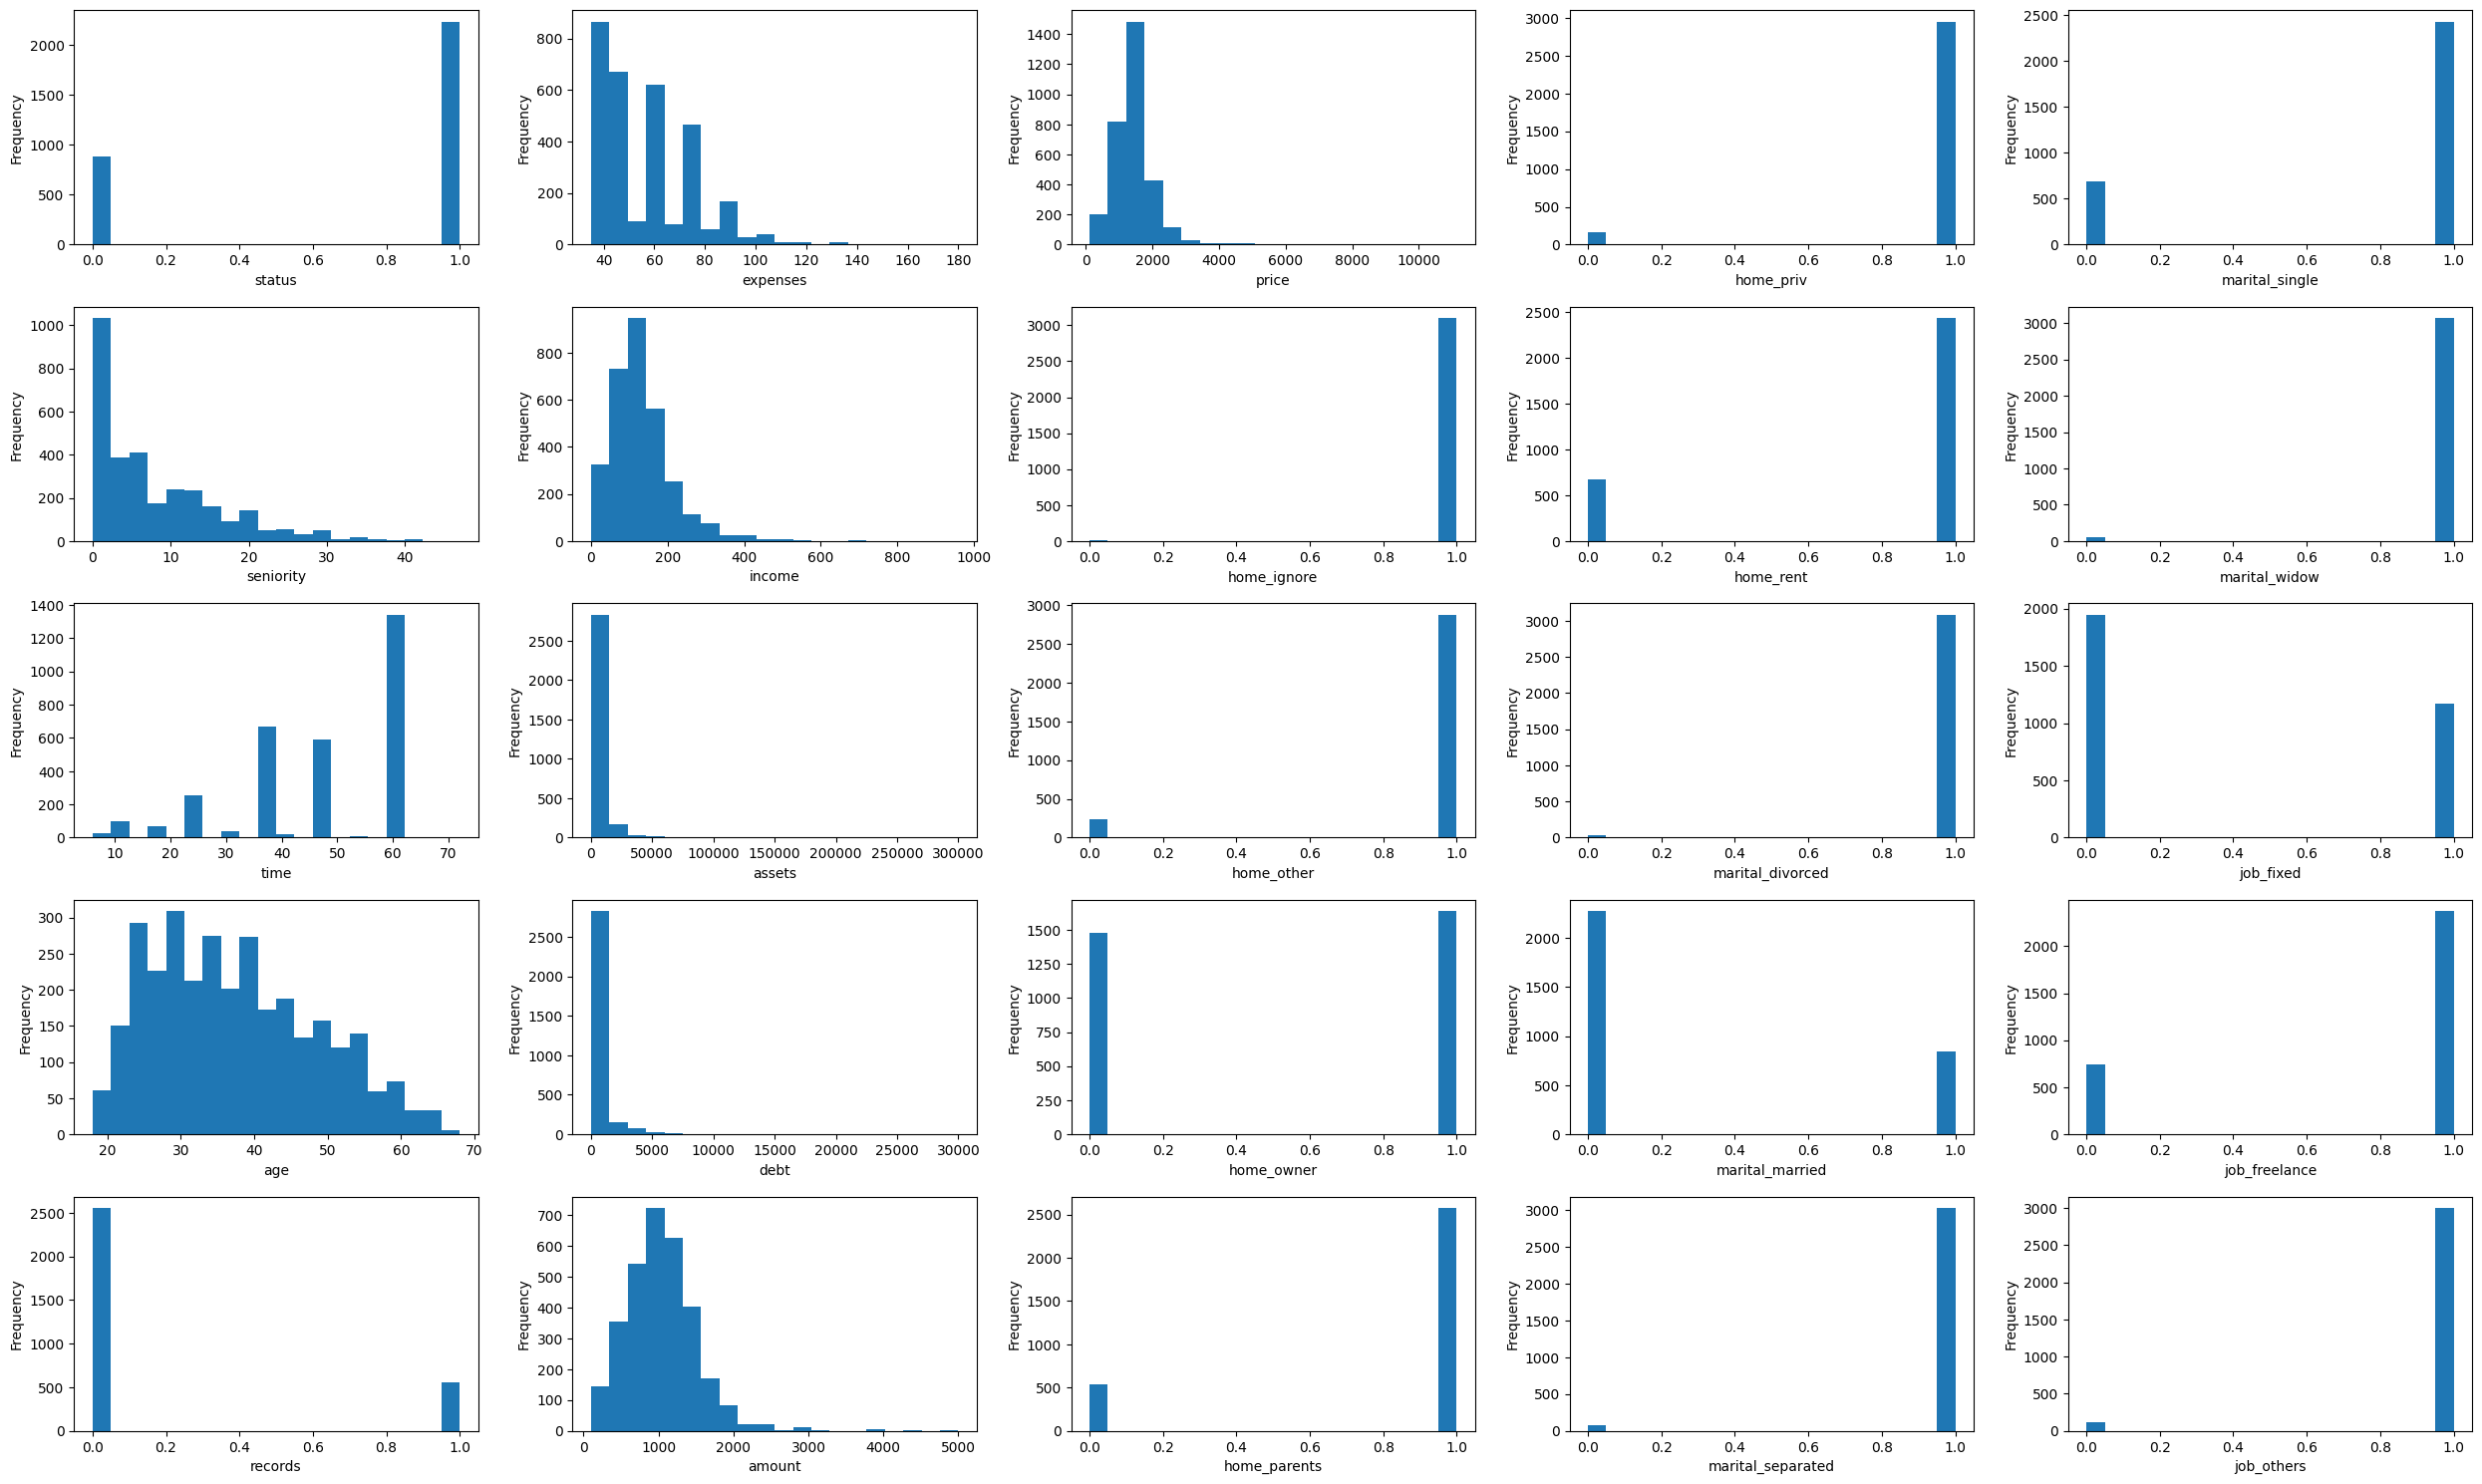

In [33]:
show_frequency(df, cols=5, rows=5)

In [34]:
#sns.pairplot(df.iloc[:, :11], hue='status', diag_kind='kde')

In [35]:
def split_dataframe(df: pd.DataFrame, target_column: str):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target_column]), df[target_column], test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

In [36]:
X_train, X_test, y_train, y_test = split_dataframe(df, target_column='status')

In [37]:
X_train

,seniority,time,age,records,expenses,income,assets,debt,amount,price,home_ignore,home_other,home_owner,home_parents,home_priv,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
626,12,36,46,1,60,117.0,3000.0,0.0,825,1325,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
347,15,60,43,0,75,126.0,3000.0,0.0,1350,1360,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1
278,12,48,35,0,45,125.0,6000.0,0.0,350,1511,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
1938,8,60,33,0,75,160.0,0.0,0.0,1200,1506,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1
2375,2,36,49,1,75,154.0,14000.0,0.0,850,1263,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,2,48,41,0,75,120.0,7500.0,4750.0,900,1411,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
1095,13,36,60,0,60,116.0,4000.0,0.0,1000,1100,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
1130,4,60,22,0,35,130.0,4000.0,0.0,750,997,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1
1294,13,48,28,0,90,105.0,0.0,0.0,1200,1590,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1


In [38]:
def reset_index(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> tuple[pd.DataFrame]:
    for d in [X_train, X_test, y_train, y_test]:
        d.reset_index(inplace=True, drop=True)

    return X_train, X_test, y_train, y_test

In [39]:
X_train, X_test, y_train, y_test = reset_index(X_train, X_test, y_train, y_test)

In [40]:
def emited_nan(df: pd.DataFrame, columns: tuple[str], type: str) -> pd.DataFrame:
    for c in columns:
        df[c].fillna(
            df[c].mean() if type == 'mean' else df[c].median() if type == 'median' else df[c].mode(),
            inplace=True
        )
    
    return df

In [41]:
cleaned_df = emited_nan(X_train, columns=('income', 'assets', 'debt'), type='mean')

C:\Users\Home\AppData\Local\Temp\ipykernel_1044\2543579709.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(


In [42]:
X_train.isna().sum()

seniority            0
time                 0
age                  0
records              0
expenses             0
income               0
assets               0
debt                 0
amount               0
price                0
home_ignore          0
home_other           0
home_owner           0
home_parents         0
home_priv            0
home_rent            0
marital_divorced     0
marital_married      0
marital_separated    0
marital_single       0
marital_widow        0
job_fixed            0
job_freelance        0
job_others           0
job_partime          0
dtype: int64

In [43]:
income_nan = X_train['income'].isna()
assets_nan = X_train['assets'].isna()
debt_nan = X_train['debt'].isna()

In [44]:
print(cleaned_df[income_nan].isna().sum().sum())
print(cleaned_df[assets_nan].isna().sum().sum())
print(cleaned_df[debt_nan].isna().sum().sum())
cleaned_df.isna().sum()

0
0
0


seniority            0
time                 0
age                  0
records              0
expenses             0
income               0
assets               0
debt                 0
amount               0
price                0
home_ignore          0
home_other           0
home_owner           0
home_parents         0
home_priv            0
home_rent            0
marital_divorced     0
marital_married      0
marital_separated    0
marital_single       0
marital_widow        0
job_fixed            0
job_freelance        0
job_others           0
job_partime          0
dtype: int64

In [45]:
class ScalerData():
    types = ['standard', 'robust']

    def __init__(self, X: pd.DataFrame, y: pd.DataFrame, columns: tuple[str], type: str) -> None:
        self.valide_type(type)

        self.columns = columns
        self.scaler = StandardScaler() if type == 'standard' else RobustScaler()
        self.scaler.fit(X[self.columns], y)

    @classmethod
    def valide_type(cls, _type: str) -> None:
        if type(_type) is str and _type not in cls.types:
            join_types = ', '.join(cls.types)
            raise ValueError(f'{_type} isn\'t {join_types}')
        
        if type(_type) is not str:
            raise TypeError(f'{_type} don\'t str type')

    def scalData(self, X: pd.DataFrame) -> pd.DataFrame:
        scaled_X = self.scaler.transform(X[self.columns])
        scaled_X_df = pd.DataFrame(scaled_X, columns=self.columns)
        added_bool_df = pd.concat([scaled_X_df.loc[:, self.columns], X.drop(columns=self.columns)], axis=1)

        return added_bool_df

In [46]:
scaler1 = ScalerData(cleaned_df, y_train, columns=['age'], type='standard')
scaled_X_train = scaler1.scalData(X_train)

scaler2 = ScalerData(scaled_X_train, y_train, columns=['income', 'seniority', 'assets', 'time', 'expenses', 'debt', 'price', 'amount'], type='robust')
scaled_X_train = scaler2.scalData(scaled_X_train)

In [47]:
scaled_X_train.isna().sum()

income               0
seniority            0
assets               0
time                 0
expenses             0
debt                 0
price                0
amount               0
age                  0
records              0
home_ignore          0
home_other           0
home_owner           0
home_parents         0
home_priv            0
home_rent            0
marital_divorced     0
marital_married      0
marital_separated    0
marital_single       0
marital_widow        0
job_fixed            0
job_freelance        0
job_others           0
job_partime          0
dtype: int64

In [48]:
scaled_X_train.shape, cleaned_df.shape

((2181, 25), (2181, 25))

# Nu am reusit sa prelucrez outliersii

In [49]:
#def remove_outliers_standard(scaler, df: pd.DataFrame, columns: tuple[str]) -> pd.DataFrame:
#    scaled_values = scaler.scalData(df)
#
#    outliers = np.abs(scaled_values) > 3
#    
#    for column in columns:
#        median = df[column].median()
#        df.loc[outliers.loc[:, column], column] = median
#    
#    return df


#NOT WORK!!!
#def remove_outliers_robust(scaler: ScalerData, df: pd.DataFrame, columns: tuple[str]) -> pd.DataFrame:
#    scaled_values = scaler.scalData(df)
#
#    Q1 = df[columns].quantile(0.25)
#    Q3 = df[columns].quantile(0.75)
#    IQR = Q3 - Q1
#    
#    lower_bound = Q1 - 1.5 * IQR
#    upper_bound = Q3 + 1.5 * IQR
#
#    for column in columns:
#        median = df[column].median()
#        outlier_condition = (df[column] < lower_bound[column]) | (df[column] > upper_bound[column])
#        df.loc[outlier_condition, column] = median
#    
#    return df

In [50]:
cleaned_df

,seniority,time,age,records,expenses,income,assets,debt,amount,price,home_ignore,home_other,home_owner,home_parents,home_priv,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
0,12,36,46,1,60,117.0,3000.0,0.0,825,1325,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
1,15,60,43,0,75,126.0,3000.0,0.0,1350,1360,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1
2,12,48,35,0,45,125.0,6000.0,0.0,350,1511,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
3,8,60,33,0,75,160.0,0.0,0.0,1200,1506,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1
4,2,36,49,1,75,154.0,14000.0,0.0,850,1263,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,2,48,41,0,75,120.0,7500.0,4750.0,900,1411,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
2177,13,36,60,0,60,116.0,4000.0,0.0,1000,1100,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
2178,4,60,22,0,35,130.0,4000.0,0.0,750,997,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1
2179,13,48,28,0,90,105.0,0.0,0.0,1200,1590,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1


In [51]:
#scaler1 = ScalerData(cleaned_df, y_train, columns=['age'], type='standard')
#removed_outliers1 = remove_outliers_standard(scaler1, cleaned_df, columns=['age'])

In [52]:
#show_boxplots(removed_outliers1, rows=5, cols=5)

In [53]:
#scaler2 = ScalerData(X_train, y_train, columns=['income', 'seniority', 'assets', 'time', 'expenses', 'debt', 'price', 'amount'], type='robust')
#removed_outliers2 = remove_outliers_standard(scaler2, X_train, columns=['income', 'seniority', 'assets', 'time', 'expenses', 'price', 'amount'])

In [54]:
#removed_outliers2

In [55]:
#removed_outliers2['income'].value_counts()

In [56]:
#show_boxplots(removed_outliers2, rows=5, cols=5)


In [57]:
scaled_X_train

,income,seniority,assets,time,expenses,debt,price,amount,age,records,home_ignore,home_other,home_owner,home_parents,home_priv,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
0,-0.024096,0.7,-0.083333,-0.5,0.250,0.0,-0.132275,-0.291667,0.803646,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
1,0.084337,1.0,-0.083333,0.5,0.625,0.0,-0.070547,0.583333,0.531789,0,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1
2,0.072289,0.7,0.416667,0.0,-0.125,0.0,0.195767,-1.083333,-0.193163,0,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
3,0.493976,0.3,-0.583333,0.5,0.625,0.0,0.186949,0.333333,-0.374401,0,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1
4,0.421687,-0.3,1.750000,-0.5,0.625,0.0,-0.241623,-0.250000,1.075504,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,0.012048,-0.3,0.666667,0.0,0.625,4750.0,0.019400,-0.166667,0.350551,0,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1
2177,-0.036145,0.8,0.083333,-0.5,0.250,0.0,-0.529101,0.000000,2.072313,0,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1
2178,0.132530,-0.1,0.083333,0.5,-0.375,0.0,-0.710758,-0.416667,-1.371210,0,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1
2179,-0.168675,0.8,-0.583333,0.0,1.000,0.0,0.335097,0.333333,-0.827496,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1


In [58]:
scaled_X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   income             2181 non-null   float64
 1   seniority          2181 non-null   float64
 2   assets             2181 non-null   float64
 3   time               2181 non-null   float64
 4   expenses           2181 non-null   float64
 5   debt               2181 non-null   float64
 6   price              2181 non-null   float64
 7   amount             2181 non-null   float64
 8   age                2181 non-null   float64
 9   records            2181 non-null   int64  
 10  home_ignore        2181 non-null   int64  
 11  home_other         2181 non-null   int64  
 12  home_owner         2181 non-null   int64  
 13  home_parents       2181 non-null   int64  
 14  home_priv          2181 non-null   int64  
 15  home_rent          2181 non-null   int64  
 16  marital_divorced   2181 

5it [00:00, 41.38it/s]00:00<?, ?it/s]
5it [00:00, 42.80it/s]00:00<00:00,  7.92it/s]
5it [00:00, 44.72it/s]00:00<00:00,  8.05it/s]
5it [00:00, 42.26it/s]00:00<00:00,  8.23it/s]
5it [00:00, 37.49it/s]00:00<00:00,  8.17it/s]
100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


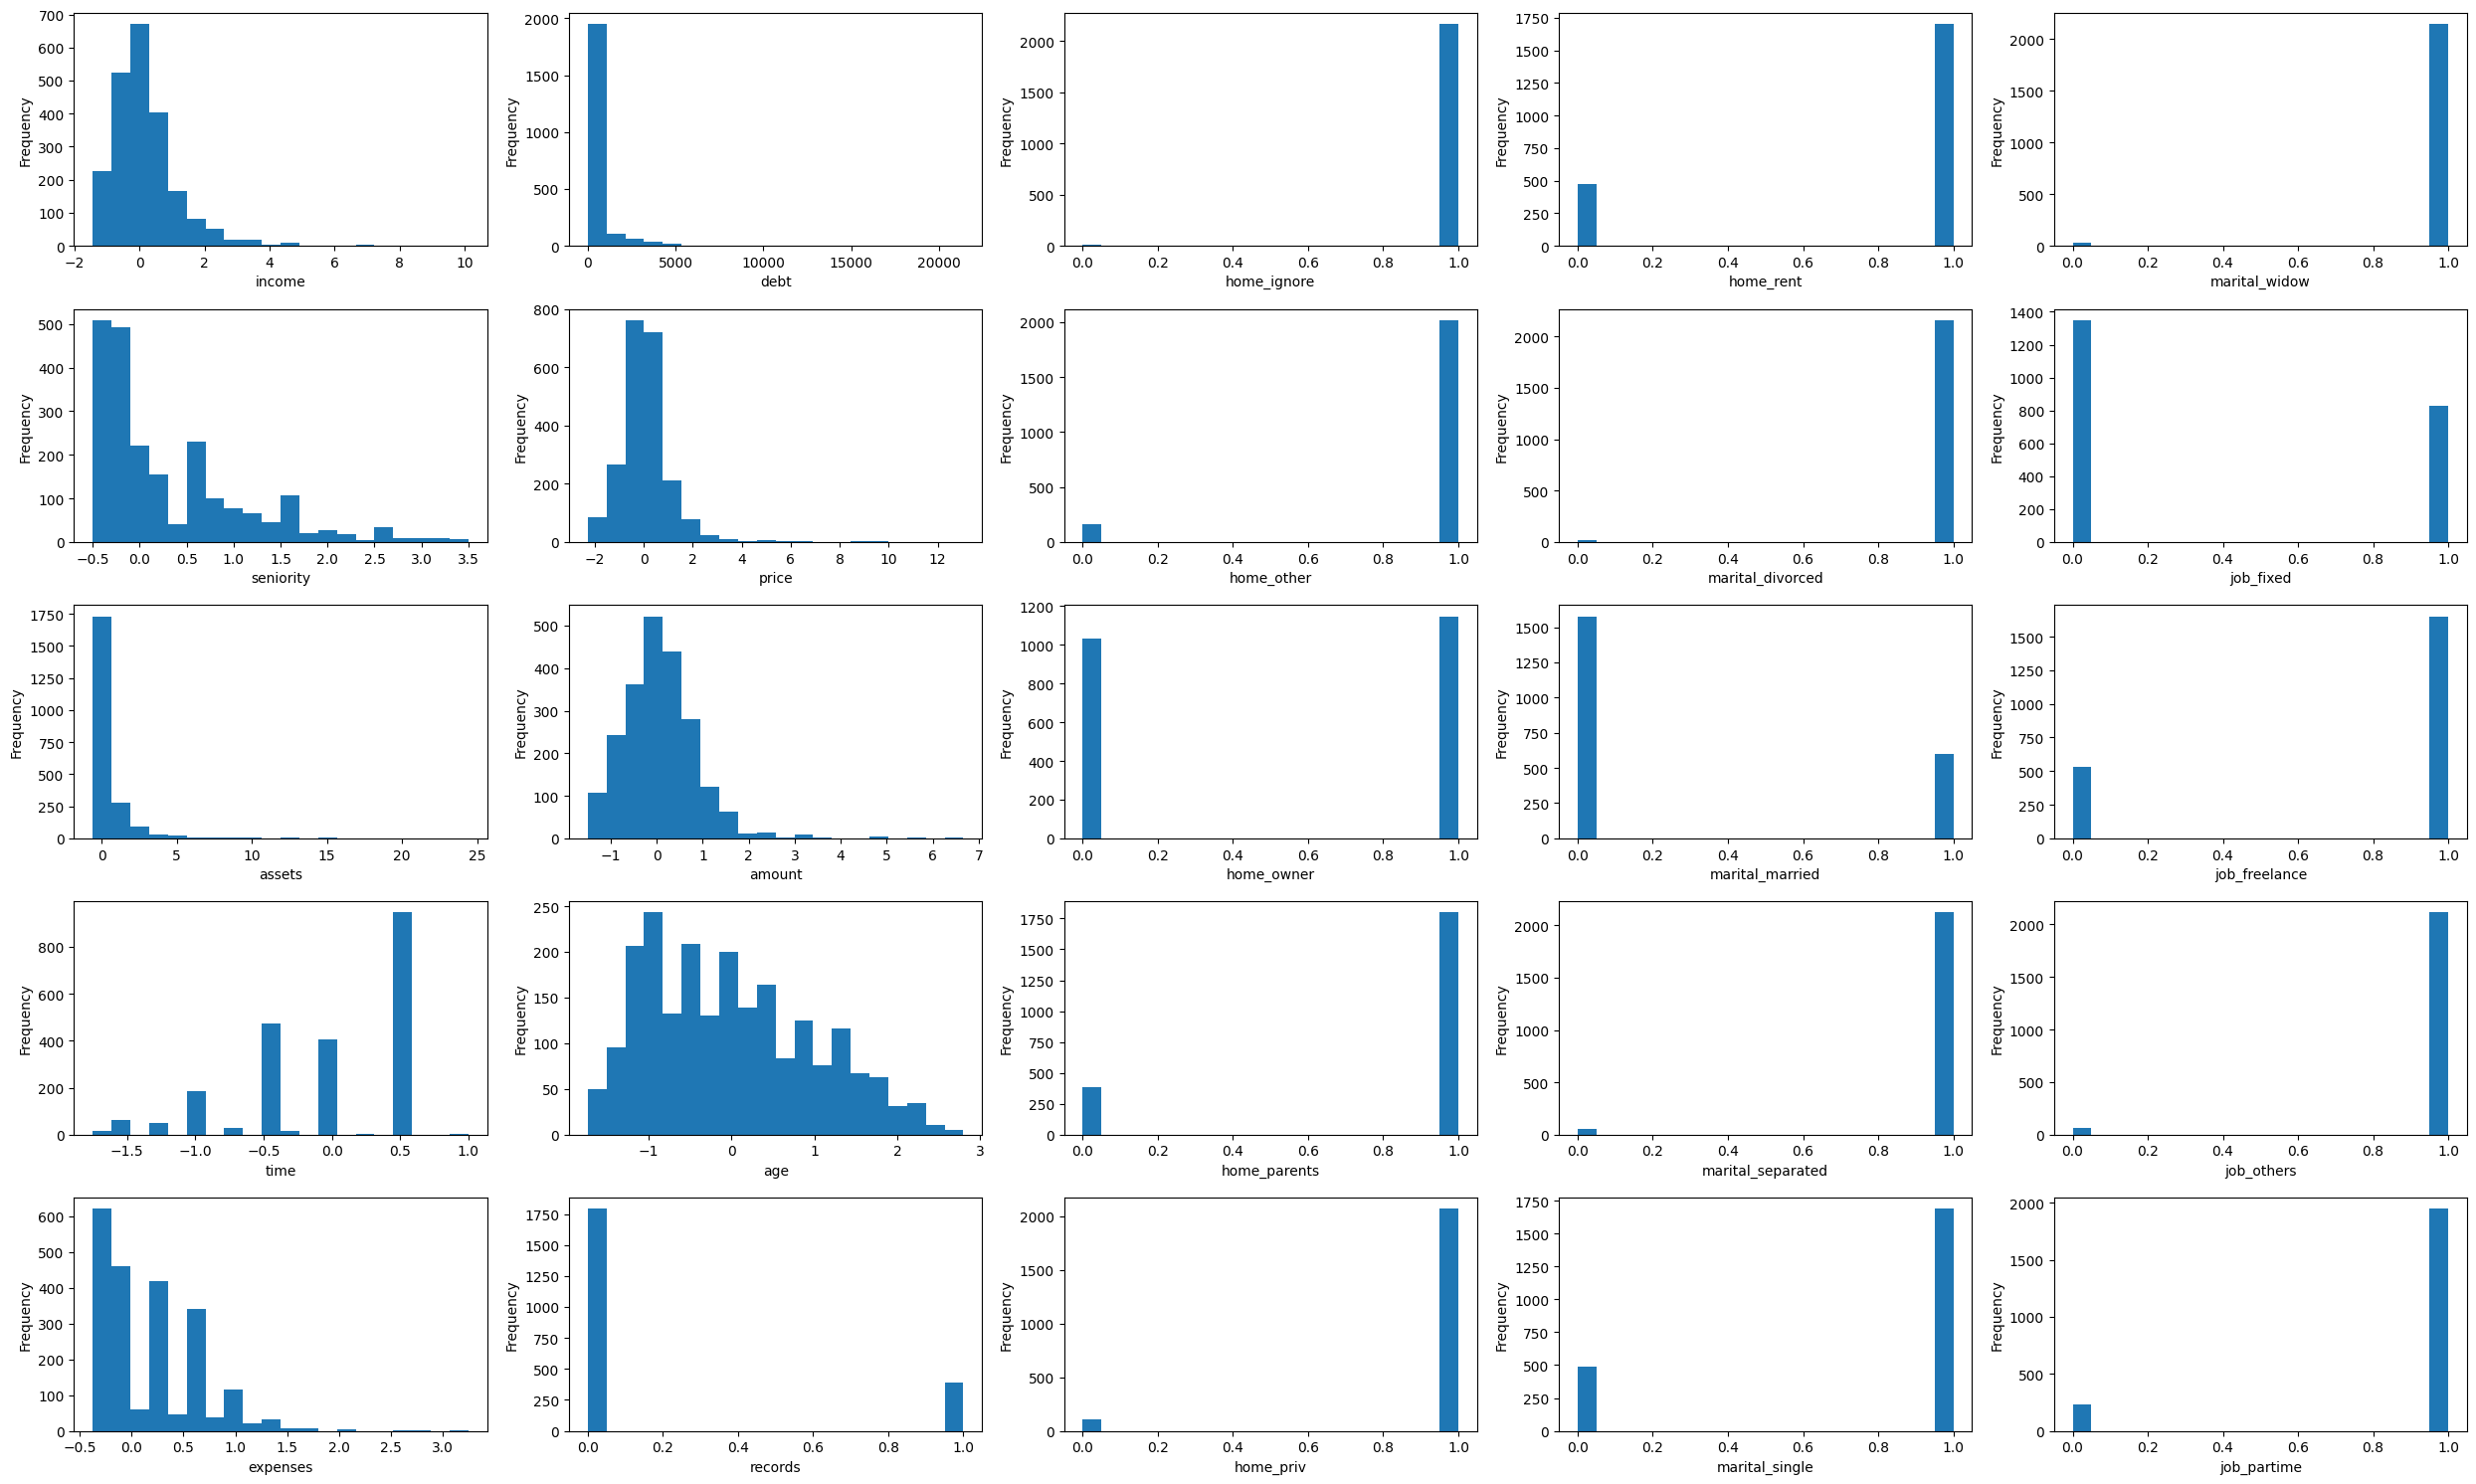

In [59]:
show_frequency(scaled_X_train, cols=5, rows=5)

5it [00:00, 132.93it/s]0:00<?, ?it/s]
5it [00:00, 136.49it/s]
5it [00:00, 138.52it/s]
5it [00:00, 142.48it/s]0:00<00:00, 24.42it/s]
5it [00:00, 142.47it/s]
100%|██████████| 5/5 [00:00<00:00, 24.74it/s]


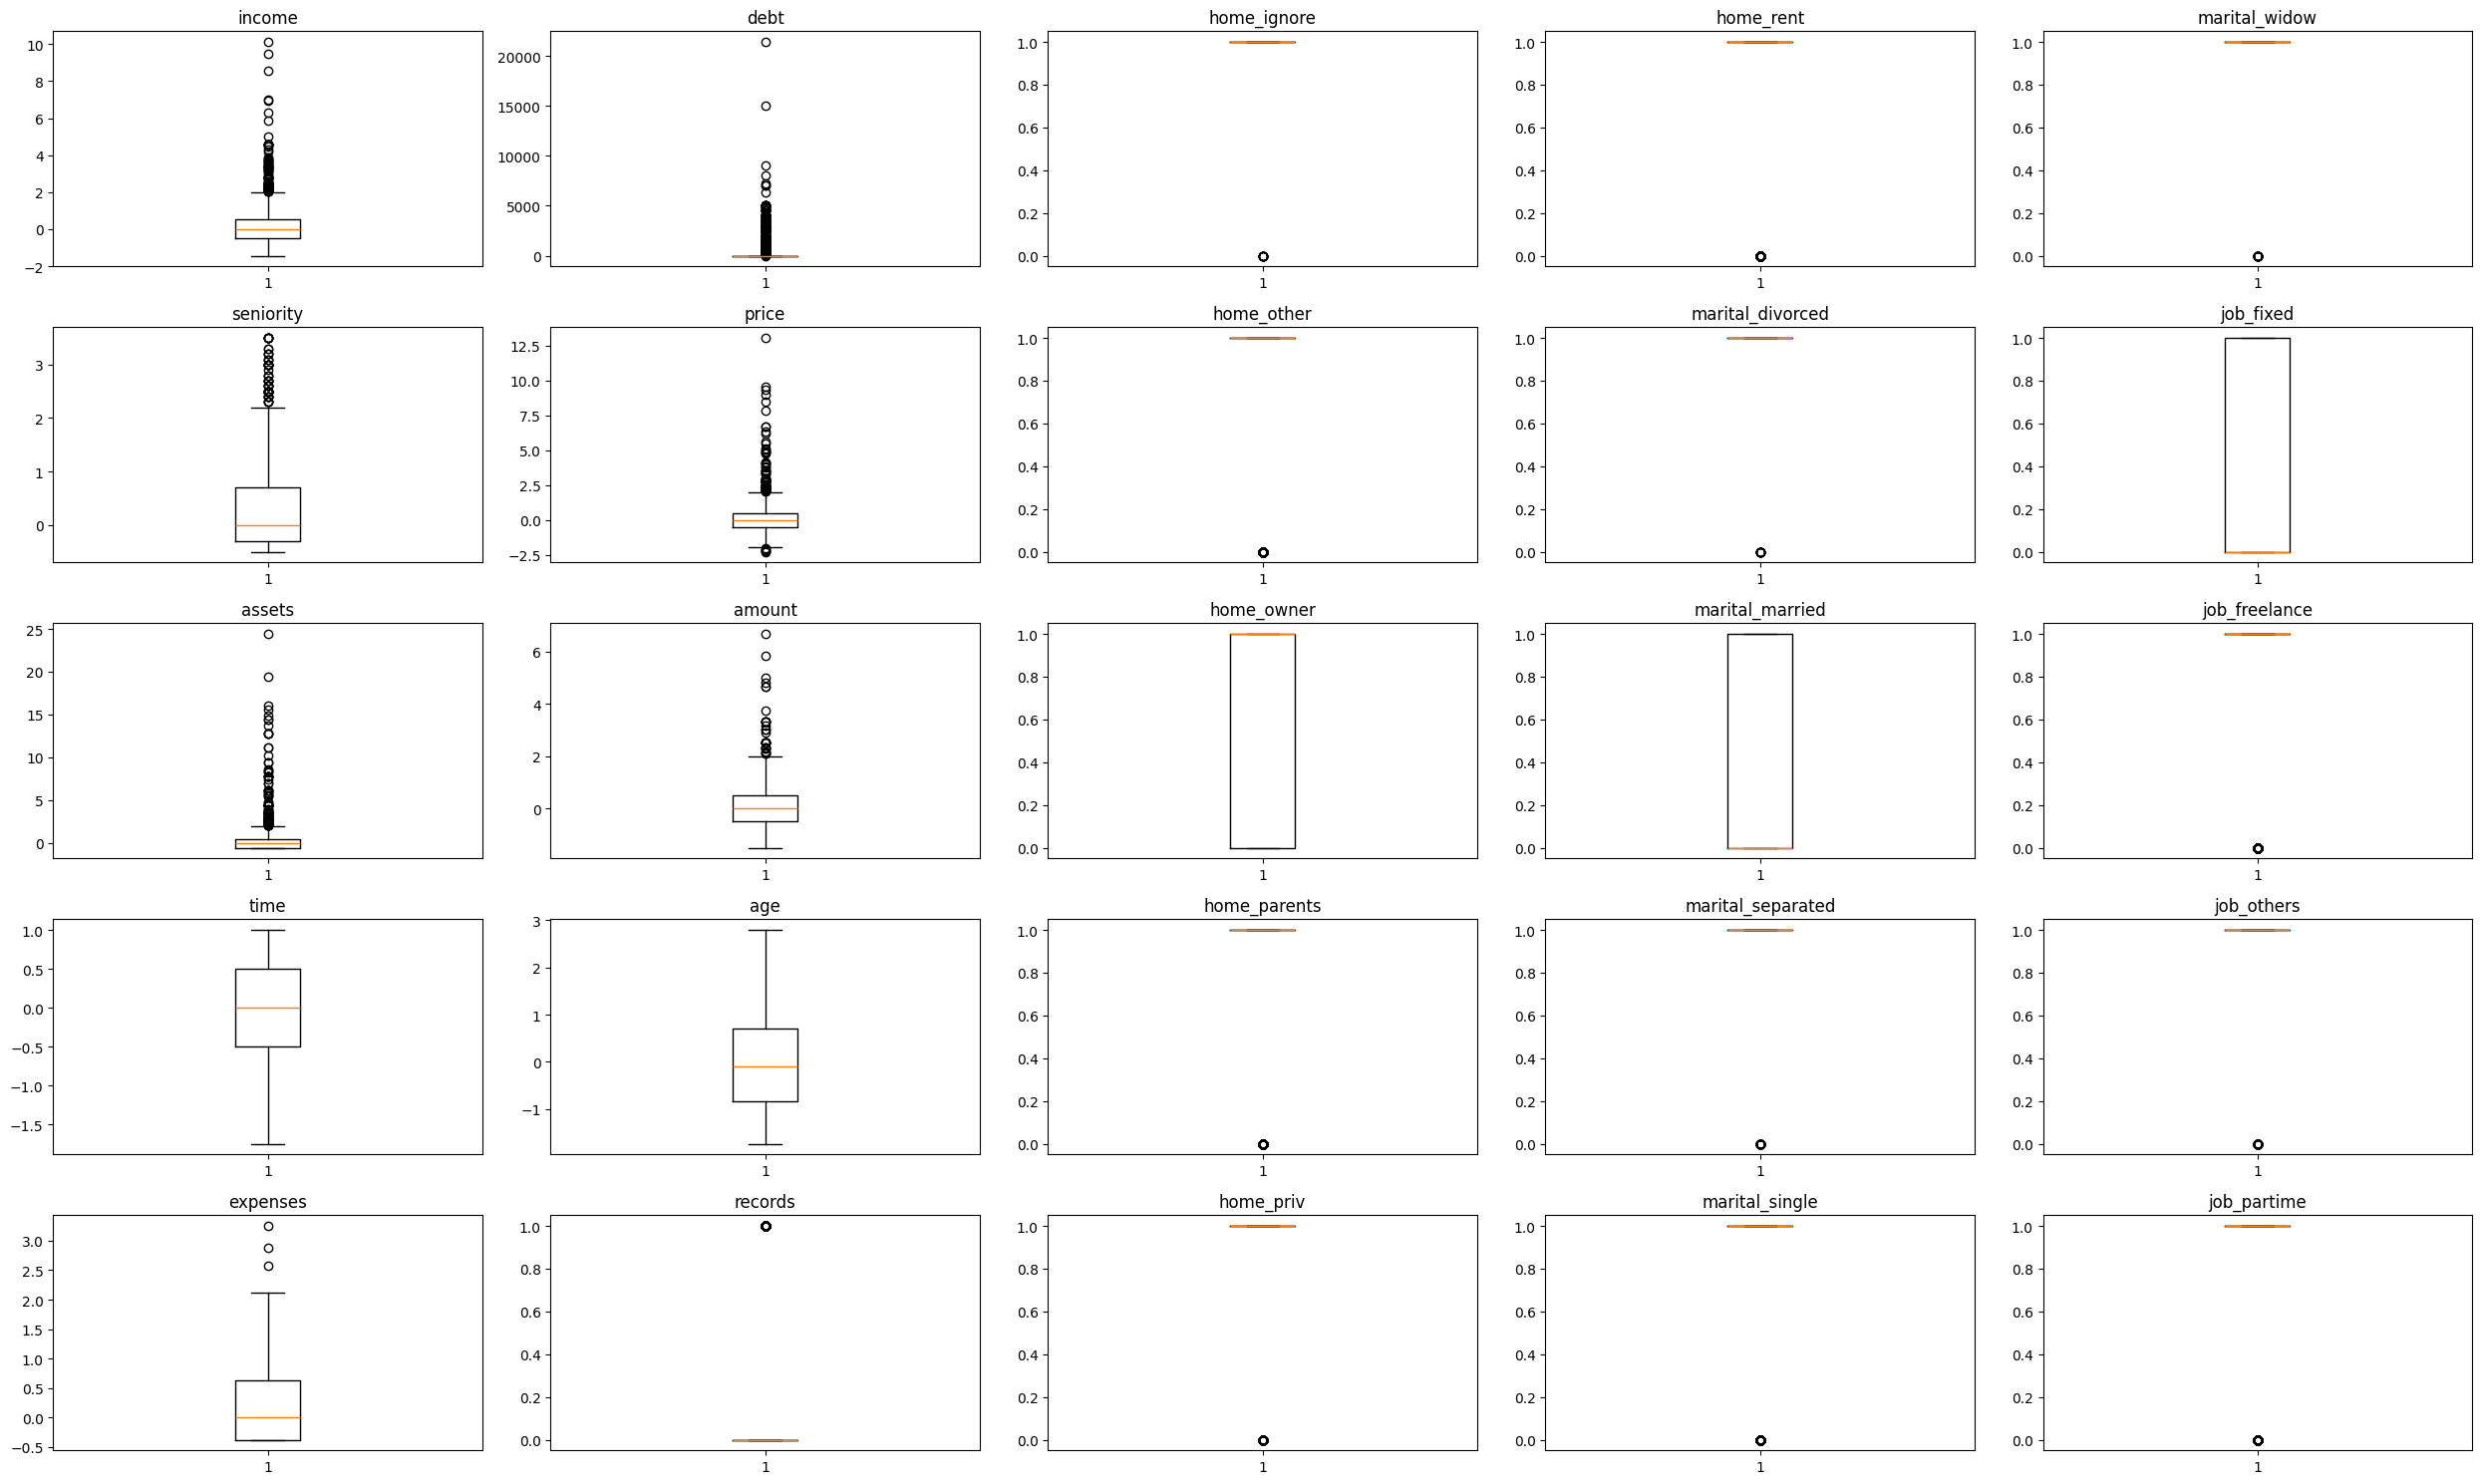

In [60]:
show_boxplots(scaled_X_train, rows=5, cols=5)

In [61]:
scaled_X_train.isna().sum()

income               0
seniority            0
assets               0
time                 0
expenses             0
debt                 0
price                0
amount               0
age                  0
records              0
home_ignore          0
home_other           0
home_owner           0
home_parents         0
home_priv            0
home_rent            0
marital_divorced     0
marital_married      0
marital_separated    0
marital_single       0
marital_widow        0
job_fixed            0
job_freelance        0
job_others           0
job_partime          0
dtype: int64

In [62]:
abs_X_train = scaled_X_train.abs()
chi2_scores, p_values = chi2(abs_X_train, y_train)
chi2_results = pd.DataFrame({
    'Columns': abs_X_train.columns,
    'chi2_score': chi2_scores,
    'p-value': p_values
})
chi2_results = chi2_results.sort_values(by='chi2_score', ascending=False)
chi2_results

,Columns,chi2_score,p-value
5,debt,3688.081956,0.000000e+00
9,records,146.672095,9.255789e-34
21,job_fixed,70.068239,5.728798e-17
12,home_owner,60.957525,5.831959e-15
1,seniority,33.532055,7.009912e-09
6,price,25.722569,3.941902e-07
15,home_rent,18.594234,1.617089e-05
7,amount,16.349950,5.265756e-05
24,job_partime,15.140439,9.980244e-05
17,marital_married,12.947512,3.203470e-04


- **home_priv** si **home_ignoe** intradevar are o importanta ne semnificativa

In [102]:
def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df.status.notnull()]
    df = status_to_int(df)
    df = delete_extreme_val(df)
    df = get_dummies(df)
    df.loc[:, df.dtypes == bool] = df.loc[:, df.dtypes == bool].apply(lambda x: x.map({True: 0, False: 1}))

    return df

def split_data(df: pd.DataFrame, target: str) -> list[pd.DataFrame]:
    X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop(columns=[target]), df[target], test_size=0.3, random_state=42)
    X_train_val, X_test, y_train_val, y_test  = reset_index(X_train_val, X_test, y_train_val, y_test)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val  = reset_index(X_train, X_val, y_train, y_val)

    return [X_train, X_val, y_train, y_val, X_test, y_test]

def load_dataset(file: str, X_train: pd.DataFrame, y_train: pd.DataFrame) -> tuple[pd.DataFrame]:
    df = pd.read_csv(file)#'CreditScoring_final.csv')
    print(df.shape, X_train.shape)
    transformed_df = transform_data(df)
    target = transformed_df['status']
    transformed_df.drop(columns=['status'], inplace=True)
    transformed_df.reset_index(inplace=True, drop=True)
    transformed_df = transform_train_test_data(X_train, y_train, transformed_df)
    transformed_df.reset_index(inplace=True, drop=True)
    transformed_df = transformed_df[X_train.columns]

    return transformed_df, target

def emited_nan_for_test(df: pd.DataFrame, test: pd.DataFrame, columns: tuple[str], type: str) -> pd.DataFrame:
    for c in columns:
        test[c].fillna(
            df[c].mean() if type == 'mean' else df[c].median() if type == 'median' else df[c].mode(),
            inplace=True
        )
    
    return test

def transform_train_test_data(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test) -> pd.DataFrame:
    cleaned_df = emited_nan(X_train, columns=('income', 'assets', 'debt'), type='mean')
    cleaned_test = emited_nan_for_test(X_train, X_test, columns=('income', 'assets', 'debt'), type='mean')

    scaler1 = ScalerData(cleaned_df, y_train, columns=['age'], type='standard')
    scaled_X_train = scaler1.scalData(cleaned_df)
    scaled_X_test = scaler1.scalData(cleaned_test)

    scaler2 = ScalerData(scaled_X_train, y_train, columns=['income', 'seniority', 'assets', 'time', 'expenses', 'debt', 'price', 'amount'], type='robust')
    scaled_X_test = scaler2.scalData(scaled_X_test)

    return scaled_X_test

# Utilizati dupa exemple de mai jos functiile pentru a incarca datasetul de testare si al testa pe model:

In [117]:
df2 = pd.read_csv('CreditScoring_final.csv')
transformed_df = transform_data(df2)
X_train, X_val, y_train, y_val, X_test, y_test = split_data(transformed_df, 'status')

transformed_X_train = transform_train_test_data(X_train, y_train, X_train)
transformed_X_val = transform_train_test_data(X_train, y_train, X_val)
transformed_X_test = transform_train_test_data(X_train, y_train, X_test)

C:\Users\Home\AppData\Local\Temp\ipykernel_1044\832745710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].astype(int)
C:\Users\Home\AppData\Local\Temp\ipykernel_1044\903179467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['income', 'assets', 'debt']] = df[['income', 'assets', 'debt']].replace({99999999: np.nan})
C:\Users\Home\AppData\Local\Temp\ipykernel_1044\1365202265.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futu

In [118]:
#model = RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=10)
#model.fit(X_train, y_train)
#
#y_train_pred = model.predict(X_train)
#y_val_pred = model.predict(X_val)
#y_test_pred = model.predict(X_test)
#
#print(f1_score(y_train, y_train_pred))
#print(f1_score(y_val, y_val_pred))
#print(f1_score(y_test, y_test_pred))

In [119]:
def verify_model_param(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    scores = []
    for max_depth in tqdm([2, 3, 4, 5, 6, 10, 12, 15, 20]):
        for min_samples_leaf in tqdm([1, 2, 3, 5, 10, 15, 18, 19, 20, 50, 100]):
            model = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, class_weight='balanced')
            model.fit(X_train, y_train)
    
            y_pred_test = model.predict(X_test)
            test_f1_score = f1_score(y_test, y_pred_test)
            
            scores.append((max_depth, min_samples_leaf, test_f1_score))

    df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'score'])

    return df_scores

In [67]:
#f1_scores_param = verify_model_param(X_train, y_train, X_val, y_val)
#df_scores_pivot = f1_scores_param.pivot(index='max_depth', columns='min_samples_leaf', values='score')
#df_scores_pivot

In [68]:
#f1_scores_param.max()

In [69]:
#pd.set_option('display.max_rows', 100)
#f1_scores_param.sort_values(by='score')

# Load data example

In [124]:
X, y = load_dataset('CreditScoring_final.csv', X_train, y_train)

(3118, 14) (1526, 25)
(3117, 25) (3117,)


C:\Users\Home\AppData\Local\Temp\ipykernel_1044\832745710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].astype(int)
C:\Users\Home\AppData\Local\Temp\ipykernel_1044\903179467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['income', 'assets', 'debt']] = df[['income', 'assets', 'debt']].replace({99999999: np.nan})
C:\Users\Home\AppData\Local\Temp\ipykernel_1044\1365202265.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futu

# Model

In [120]:
model = RandomForestClassifier(n_estimators=350, min_samples_split=5, class_weight='balanced', max_depth=5, min_samples_leaf=15)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=15, min_samples_split=5,
                       n_estimators=350)

# Predict

In [121]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# F1 Score

In [122]:
print(f1_score(y_train, y_train_pred))
print(f1_score(y_val, y_val_pred))
print(f1_score(y_test, y_test_pred))

0.8481831757093081
0.8207440811724915
0.8148148148148148


In [125]:
model.predict(X)
print(f1_score(y, model.predict(X)))

0.0
